In [1]:
# connecting to drive to get the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install patool # installing the tool to unrar the dataset


     |████████████████████████████████| 81kB 2.5MB/s 


In [1]:
# importing important libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import patoolib 
# extracting the dataset 
patoolib.extract_archive('/content/drive/My Drive/X-ray.rar', outdir="/")





patool: Extracting /content/drive/My Drive/X-ray.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/X-ray.rar"
patool:     with cwd='/'
patool: ... /content/drive/My Drive/X-ray.rar extracted to `/'.


'/'

In [11]:
import os
# setting the path for each class into variables
covid_dir = os.path.join('/xdata/COVID')
normal_dir = os.path.join('/xdata/NORMAL')
pneumonia_dir = os.path.join('/xdata/PNEUMONIA')

# printing the number of images in each directory
print('total training covid images:', len(os.listdir(covid_dir)))
print('total training normal images:', len(os.listdir(normal_dir)))
print('total training pneumonia images:', len(os.listdir(pneumonia_dir)))

# printing the name of images in each directory
rock_files = os.listdir(covid_dir)
print(rock_files[:10])

paper_files = os.listdir(normal_dir)
print(paper_files[:10])

scissors_files = os.listdir(pneumonia_dir)
print(scissors_files[:10])

total training covid images: 4044
total training normal images: 3941
total training pneumonia images: 4273
['6646071b.png', 'aug_kjr-21-e24-g003-l-a_sharp_1.jpg', 'jkms-35-e79-g001-l-a.jpg', 'person1278_virus_2201.jpeg', 'COVID-19 (94).png', 'COVID-19 (357).jpg', 'jkms-35-e79-g001-l-c.jpg', 'COVID-19 (812).jpg', 'person1303_virus_2243.jpeg', 'covid (2).jpg']
['NORMAL2-IM-0949-0001.jpeg', 'IM-0487-0001.jpeg', 'Non-COVID-19 (300).jpeg', 'Non-COVID-19 (161).jpg', '00002556_000.png', 'IM-0650-0001-0001.jpeg', '00001323_001.png', 'IM-0213-0001.jpeg', 'NORMAL2-IM-0834-0001.jpeg', 'Non-COVID-19 (166).jpeg']
['person97_bacteria_468.jpeg', 'person1278_virus_2201.jpeg', 'person292_bacteria_1378.jpeg', 'person257_bacteria_1200.jpeg', 'person258_bacteria_1209.jpeg', 'person66_bacteria_325.jpeg', 'person428_bacteria_1869.jpeg', 'person30_bacteria_149.jpeg', 'person258_bacteria_1205.jpeg', 'person498_bacteria_2101.jpeg']


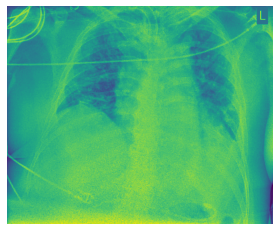

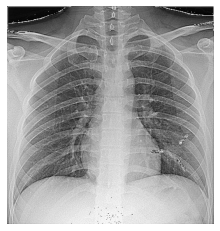

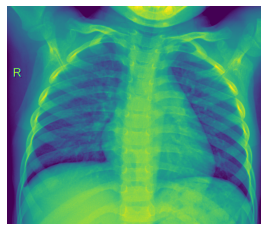

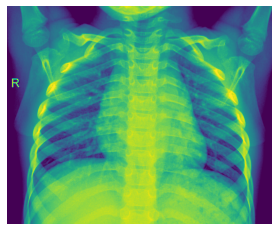

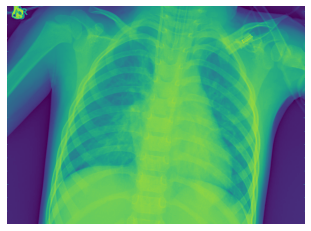

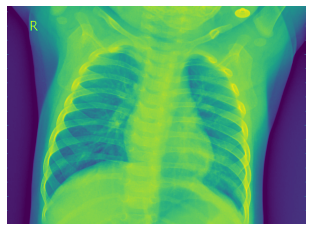

In [4]:
%matplotlib inline
import matplotlib.image as mpimg

pic_index = 2

next_covid = [os.path.join(covid_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
                
next_normal = [os.path.join(normal_dir, fname)  for fname in paper_files[pic_index-2:pic_index]]

next_pneumonia = [os.path.join(pneumonia_dir, fname)   for fname in scissors_files[pic_index-2:pic_index]]

# showing 2 pictures for each class
for i, img_path in enumerate(next_covid+next_normal+next_pneumonia):

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [12]:
# Loading the data from the directory of train and test

TRAINING_DIR = '/xdata/'  # change the name of the unrarred dataset to 'xdata' to use the full sized data as train
train_datagen = ImageDataGenerator( rescale=1.0/255 ) # rescaling the training data only , as it's already modified


# uploading the training data and the training labels from the directory , categorical as we have 3 categories, 
#set the size of images to suite the model, batch size of the images being fed to the model during training 
train_generator = train_datagen.flow_from_directory(
                                              TRAINING_DIR , target_size=(224, 224),  
                                              batch_size=126,
                                              class_mode='categorical') 

# same as training, we use validation to validate our model performance during training and see how it performs

VALIDATION_DIR = "/content/drive/My Drive/datasets/train/"
validation_datagen = ImageDataGenerator(rescale = 1./255)


validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=126
)


# test generator to see how our model performs after training on random images

TEST_DIR = '/content/drive/My Drive/datasets/test/' 
test_datagen = ImageDataGenerator( rescale=1.0/255 ) 


# TEST GENERATOR.
test_generator = test_datagen.flow_from_directory(
                                              TEST_DIR , target_size=(224, 224),
                                              class_mode='categorical') 

Found 12251 images belonging to 3 classes.
Found 270 images belonging to 3 classes.
Found 326 images belonging to 3 classes.


[0. 1. 0.]


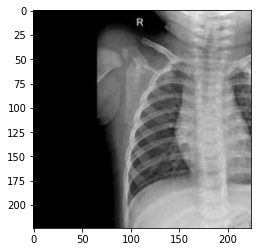

[0. 1. 0.]


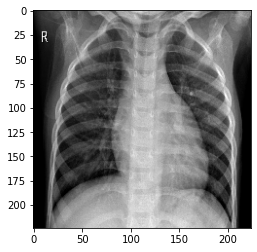

[1. 0. 0.]


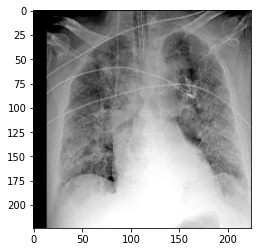

[0. 0. 1.]


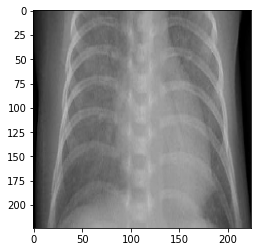

[0. 1. 0.]


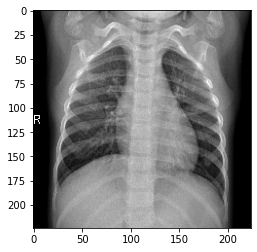

[0. 0. 1.]


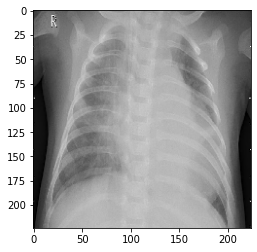

[1. 0. 0.]


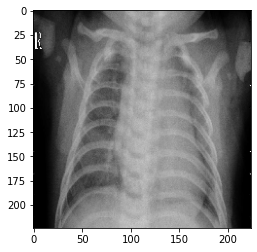

[0. 1. 0.]


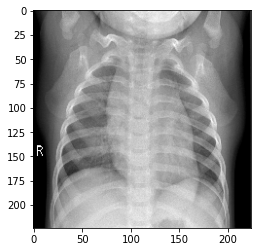

[0. 1. 0.]


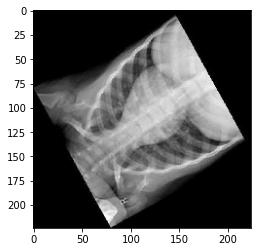

[1. 0. 0.]


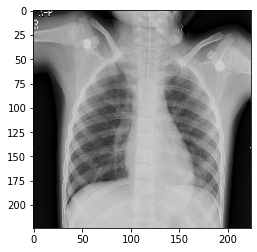

In [13]:
# to visualize the data in the generators

x_batch, y_batch = next(train_generator)  # you can inspect the data in any generator
for i in range (0,10):
    image = x_batch[i]
    plt.imshow(image)
    print(y_batch[i])
    plt.show()

In [14]:
# using the resnet model
from tensorflow.keras.applications import ResNet50
pre_trained_model = ResNet50(input_shape = (224, 224 , 3), include_top = False , pooling='avg' , weights = 'imagenet' ) 
# cutting the top layers to make it work on our new images, setting the pooling to avg as to take the average of output of the model, 
# setting the model weights to imagenet weights as they are  trained on large dataset 

pre_trained_model.trainable = False # to specify that we don't want to train the loaded model 


In [20]:
# creating a new model using the pretrained one as the head of the model and then build our layers under it

model=tf.keras.Sequential([
                           pre_trained_model,
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense( 1028, activation='relu') ,
                           tf.keras.layers.Dropout(0.3) ,
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense( 1028, activation='relu') ,
                           tf.keras.layers.Dropout(0.3) ,
                           tf.keras.layers.Dense( 1028, activation='relu') ,
                           tf.keras.layers.Dropout(0.3) ,
                           tf.keras.layers.Dense(3,  activation='softmax')
])



# opt=tf.keras.optimizers.RMSprop( 0.001,momentum=0.9 ) # setting our optimizer to optimize the training performance 

model.compile(optimizer='adam' , loss = 'categorical_crossentropy', metrics = ['accuracy'] ) # compiling our model and setting our loss function and metrics 
# we set the loss as categorical as we have categorical problem not binary

model.summary() # printing the summary of the model

# setting a callback for the model, which makes the model save it's weights each epoch while training, and only save the best model depending on the validation loss
cb=tf.keras.callbacks.ModelCheckpoint(
                                      f'checkpoint_test' , monitor='val_loss', verbose=0, save_best_only=True,
                                      save_weights_only=False, mode='auto', save_freq='epoch' )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_16 (Dense)             (None, 1028)              2106372   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1028)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1028)              4112      
_________________________________________________________________
dense_17 (Dense)             (None, 1028)              1057812   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1028)             

In [21]:
history = model.fit(train_generator, validation_data= validation_generator ,
                    epochs = 40, shuffle=True, workers=-1,
                    verbose = 1,callbacks=cb)
'''history = model.fit(
              x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,
                  validation_split=0.0, validation_data=None, shuffle=True, class_weight=None,
                  sample_weight=None, initial_epoch=0, steps_per_epoch=None,
                  validation_steps=None, validation_batch_size=None, validation_freq=1,
                  max_queue_size=10, workers=1, use_multiprocessing=False )'''

Epoch 1/40
98/98 [==============================] - 176s 2s/step - loss: 0.8476 - accuracy: 0.6646 - val_loss: 1.1944 - val_accuracy: 0.3333
Epoch 2/40
98/98 [==============================] - 179s 2s/step - loss: 0.6237 - accuracy: 0.7332 - val_loss: 1.1496 - val_accuracy: 0.3333
Epoch 3/40
98/98 [==============================] - 177s 2s/step - loss: 0.5861 - accuracy: 0.7477 - val_loss: 1.0015 - val_accuracy: 0.3815
Epoch 4/40
98/98 [==============================] - 177s 2s/step - loss: 0.5442 - accuracy: 0.7659 - val_loss: 0.7451 - val_accuracy: 0.8370
Epoch 5/40
98/98 [==============================] - 176s 2s/step - loss: 0.5320 - accuracy: 0.7703 - val_loss: 0.6642 - val_accuracy: 0.7926
Epoch 6/40
98/98 [==============================] - 176s 2s/step - loss: 0.5032 - accuracy: 0.7829 - val_loss: 0.3929 - val_accuracy: 0.8926
Epoch 7/40
98/98 [==============================] - 177s 2s/step - loss: 0.5002 - accuracy: 0.7836 - val_loss: 0.3553 - val_accuracy: 0.9037
Epoch 8/40
98

'history = model.fit(\n              x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,\n                  validation_split=0.0, validation_data=None, shuffle=True, class_weight=None,\n                  sample_weight=None, initial_epoch=0, steps_per_epoch=None,\n                  validation_steps=None, validation_batch_size=None, validation_freq=1,\n                  max_queue_size=10, workers=1, use_multiprocessing=False )'

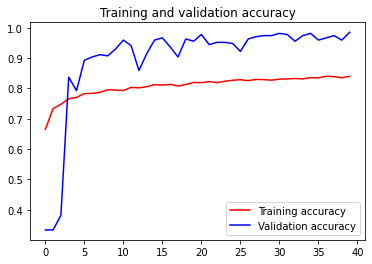

<Figure size 432x288 with 0 Axes>

In [22]:
# plotting accuracy and loss 
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [27]:
# saving the model to this directory
export_dir='model_ResNet50_Adam'
tf.saved_model.save( model , export_dir)

INFO:tensorflow:Assets written to: model_ResNet50_Adam/assets


In [29]:
!zip -r model_ResNet50_Adam.zip 'model_ResNet50_Adam'
# Download files
from google.colab import files
files.download('model_ResNet50_Adam.zip')

# to download the model as zip file 

  adding: model_ResNet50_Adam/ (stored 0%)
  adding: model_ResNet50_Adam/assets/ (stored 0%)
  adding: model_ResNet50_Adam/variables/ (stored 0%)
  adding: model_ResNet50_Adam/variables/variables.data-00000-of-00002 (deflated 82%)
  adding: model_ResNet50_Adam/variables/variables.index (deflated 79%)
  adding: model_ResNet50_Adam/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: model_ResNet50_Adam/saved_model.pb (deflated 92%)
  adding: model_ResNet50_Adam/checkpoint_test/ (stored 0%)
  adding: model_ResNet50_Adam/checkpoint_test/assets/ (stored 0%)
  adding: model_ResNet50_Adam/checkpoint_test/variables/ (stored 0%)
  adding: model_ResNet50_Adam/checkpoint_test/variables/variables.data-00000-of-00002 (deflated 82%)
  adding: model_ResNet50_Adam/checkpoint_test/variables/variables.index (deflated 79%)
  adding: model_ResNet50_Adam/checkpoint_test/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: model_ResNet50_Adam/checkpoint_test/saved_model.pb (deflated 9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictions=model.predict(test_generator) # to make predictions on the test generator


In [ ]:
# [i for i in predictions[0:10]]

[array([0.7543465 , 0.20023799, 0.04541554], dtype=float32),
 array([0.9147036 , 0.06851491, 0.01678144], dtype=float32),
 array([0.8593371 , 0.09727313, 0.04338976], dtype=float32),
 array([0.14633977, 0.7450302 , 0.10863006], dtype=float32),
 array([0.00558608, 0.98728484, 0.00712905], dtype=float32),
 array([0.9367711 , 0.05370068, 0.00952827], dtype=float32),
 array([0.01160657, 0.9672135 , 0.02118001], dtype=float32),
 array([0.00552831, 0.9856917 , 0.00877997], dtype=float32),
 array([0.48645583, 0.4941768 , 0.01936738], dtype=float32),
 array([9.9714249e-01, 7.5638626e-04, 2.1011271e-03], dtype=float32)]

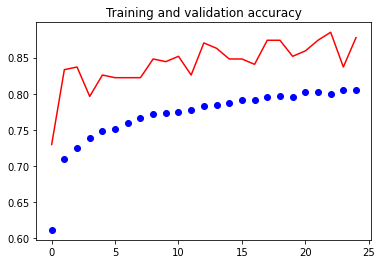

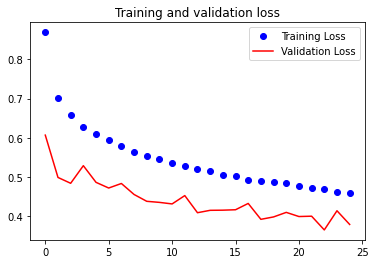

In [ ]:
# another loss and accuracy plotting
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# making predictions on images the model was not trained on

'''test = '../test_images/' # directory of test images

test_datagen = ImageDataGenerator( rescale=1.0/255 )  # preparing the test data as we done with train and valdiation

test_generator = test_datagen.flow_from_directory(
                                              test , target_size=(224, 224),
                                              class_mode='categorical',shuffle=False) '''
# to visualize the data in the generators
labels={0:'Covid' , 1:'Normal' , 2:'Pnumenia'}

predicted_label = np.argmax(history.predict( test_generator ),axis=1)
pred= [labels[x] for x in predicted_label]

x_batch, y_batch = next(test_generator) 
for i in range (0,10):
    image = x_batch[i]
    plt.imshow(image)
    print('prediction =', pred[i])
    if y_batch[i][0] == 1: print('folder= covid')
    elif y_batch[i][1] == 1: print('folder= normal')
    elif y_batch[i][2] == 1: print('folder= Nawwar')
    elif y_batch[i][3] == 1: print('folder= pnuemenia')
    plt.show()

# then feed the variable images into the predict func.
labels={0:'Covid' , 1:'Normal' , 2:'Pnumenia'}
[labels[x] for x in predicted_label]

     

In [2]:
# LOADING THE MODEL
history=tf.keras.models.load_model('model_ResNet50_Adam')
history.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
batch_normalization_8 (Batch multiple                  8192      
_________________________________________________________________
dense_16 (Dense)             multiple                  2106372   
_________________________________________________________________
dropout_12 (Dropout)         multiple                  0         
_________________________________________________________________
batch_normalization_9 (Batch multiple                  4112      
_________________________________________________________________
dense_17 (Dense)             multiple                  1057812   
_________________________________________________________________
dropout_13 (Dropout)         multiple                 

Found 9 images belonging to 3 classes.
prediction = Covid
folder= covid


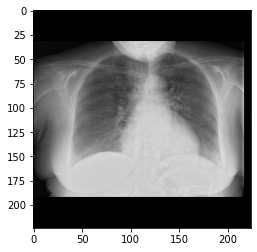

prediction = Covid
folder= covid


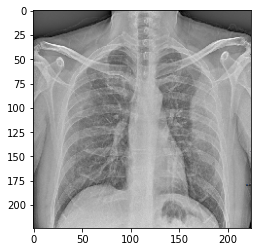

prediction = Covid
folder= covid


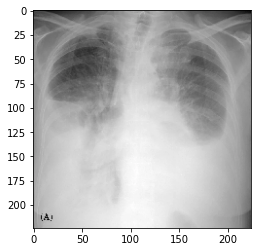

prediction = Normal
folder= normal


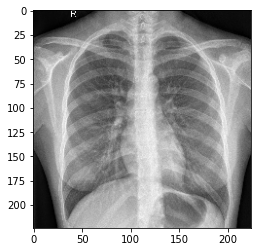

prediction = Normal
folder= normal


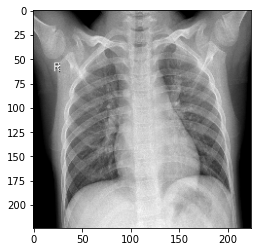

prediction = Normal
folder= normal


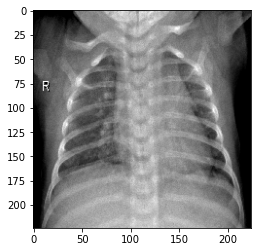

prediction = Pnumenia
folder= pnuemenia


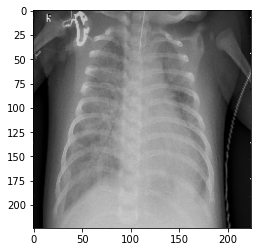

prediction = Pnumenia
folder= pnuemenia


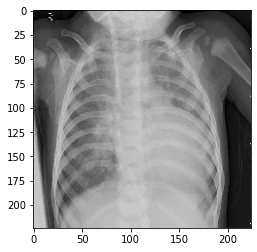

prediction = Pnumenia
folder= pnuemenia


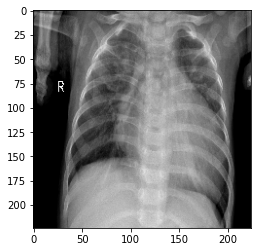

In [29]:
# making predictions on images the model was not trained on

test = '../test_images/' # directory of test images

test_datagen = ImageDataGenerator( rescale=1.0/255 )  # preparing the test data as we done with train and valdiation

test_generator = test_datagen.flow_from_directory(
                                              test , target_size=(224, 224),
                                              class_mode='categorical',shuffle=False)  
# to visualize the data in the generators
labels={0:'Covid' , 1:'Normal' , 2:'Pnumenia'}
# then feed the variable images into the predict func.
predicted_label = np.argmax(history.predict( test_generator ),axis=1)
pred= [labels[x] for x in predicted_label]

x_batch, y_batch = next(test_generator) 
for i in range (len(pred)):
    image = x_batch[i]
    plt.imshow(image)
    print('prediction =', pred[i])
    if y_batch[i][0] == 1: print('folder= covid')
    elif y_batch[i][1] == 1: print('folder= normal')
    #elif y_batch[i][2] == 1: print('folder= Nawwar')
    elif y_batch[i][2] == 1: print('folder= pnuemenia')
    plt.show()

     
    


In [28]:
history.evaluate(test_generator )

1/1 [==============================] - 1s 1s/step - loss: 0.0841 - accuracy: 1.0000


[0.08412782847881317, 1.0]